# Voxel CSV --> Neural Cellular Automata

In [1]:
from tqdm.notebook import tqdm
import wandb
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from moviepy import ImageSequenceClip

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Voxel CSV to Torch Tensor

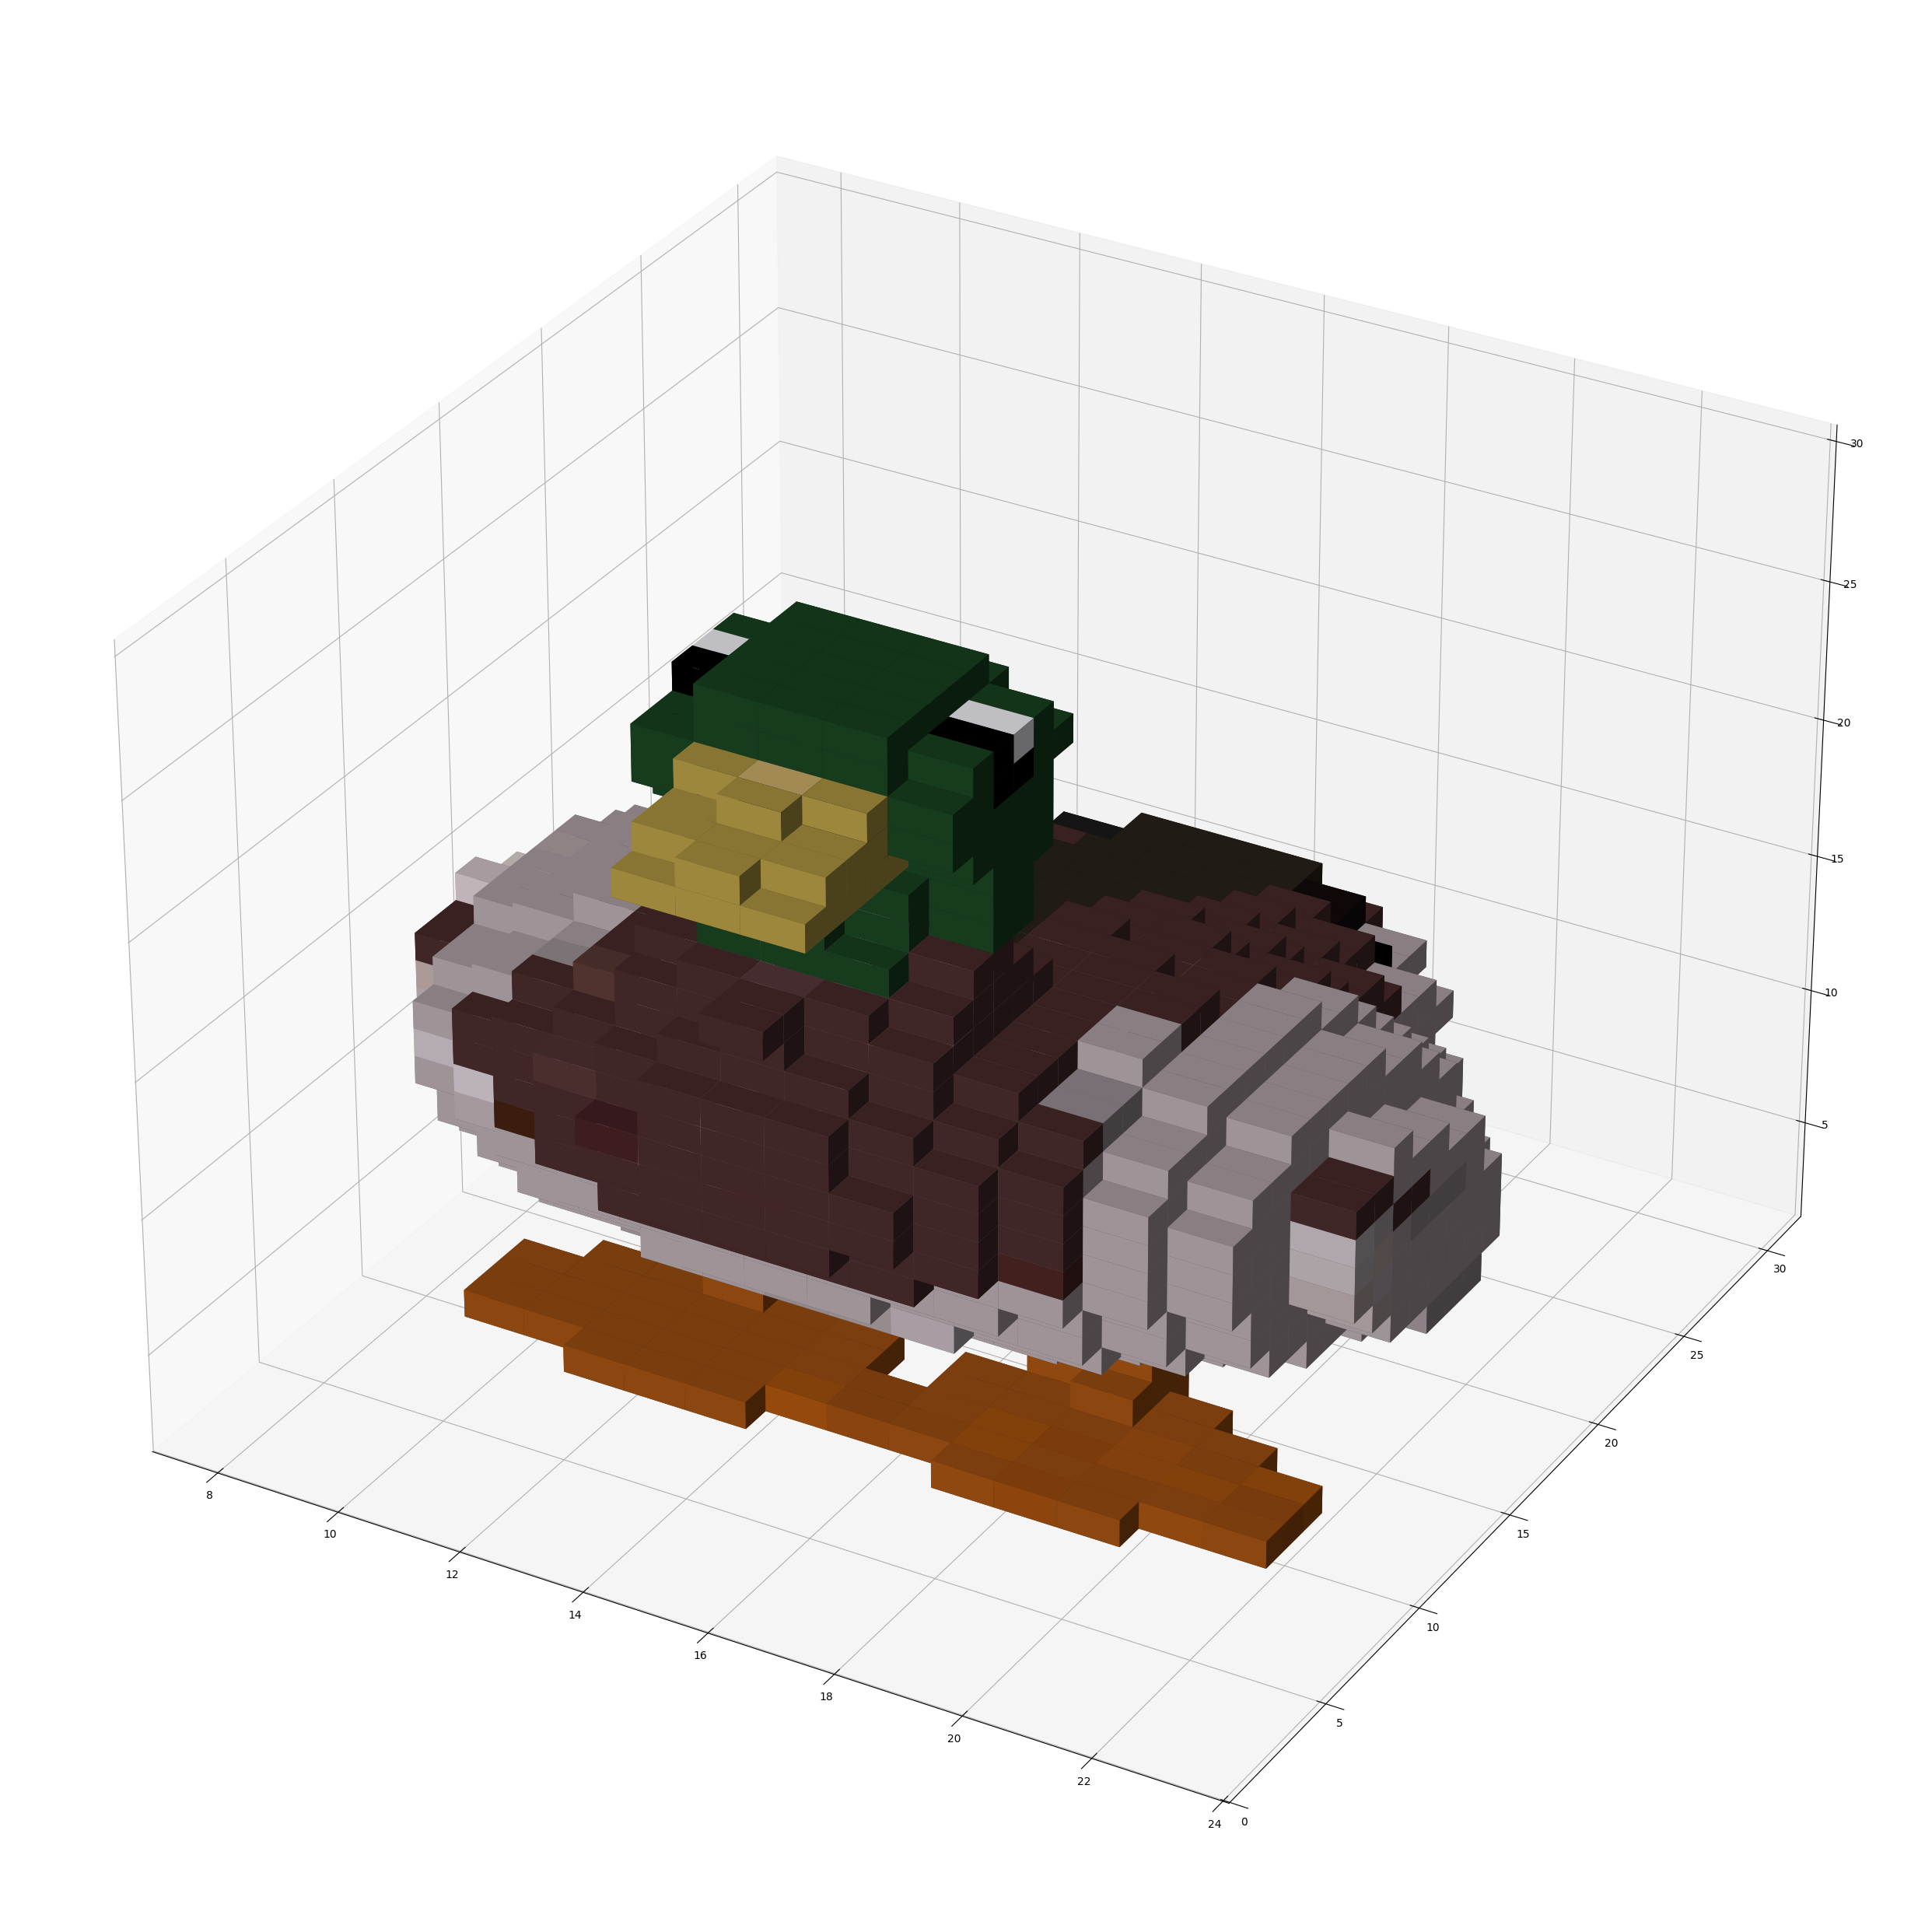

In [11]:
img_data_path = "./data/bird_15x28x28.csv"

environment_size = 32
alive_thres = 0.1
in_vox_shape = np.array([15, 28, 28])
left_padding = (environment_size - in_vox_shape) // 2

vox_data = np.array(pd.read_csv(img_data_path, header=None))
rgba_vox = np.zeros((environment_size, environment_size, environment_size, 4))

for voxel in vox_data:
    pos = tuple((voxel[:3]+left_padding))
    color = np.concatenate(((voxel[3:] / 255), np.ones(1)))
    rgba_vox[pos] = color

fig = plt.figure(figsize=(32, 32))
ax = fig.add_subplot(projection='3d')
ax.voxels(rgba_vox[..., 3] > alive_thres, facecolors=rgba_vox[..., :3])
plt.show()

rgba_voxels = torch.tensor(rgba_vox, dtype=torch.float32).permute(3, 0, 1, 2).to(device)


### Model

In [3]:
def generate_seed(n_channels, env_dim):
    seed = torch.zeros((n_channels, env_dim, env_dim, env_dim), dtype=torch.float32)
    seed[3:, env_dim//2, env_dim//2, env_dim//2] = 1.
    return seed

class NCA(nn.Module):
    '''
    Cellular Automata CNN Update Model
    TODO: Test Varying Model Sizes
    '''
    def __init__(self, n_channels, env_dim, learn_seed = True, seed_std=0.01, update_prob=0.5, alive_thres=0.1, overgrowth_to_undergrowth_penalty=0.25):
        super().__init__()
        self.update_prob = update_prob
        self.alive_thres = alive_thres
        self.overgrowth_to_undergrowth_penalty = overgrowth_to_undergrowth_penalty

        self.seed = generate_seed(n_channels, env_dim).to(device)
        if learn_seed:
            self.seed[4:, env_dim//2, env_dim//2, env_dim//2] = torch.randn(n_channels-4) * seed_std
            self.seed = nn.Parameter(self.seed)

        # TRIAL 3:
        # self.model = nn.Sequential(
        #     nn.Conv3d(n_channels, 2*n_channels, kernel_size=3, padding=1), # Perceive Surrounding states
        #     nn.LayerNorm((2 * n_channels, env_dim, env_dim, env_dim)), # I added this to prevent gradient death/explosion at higher depths
        #     nn.ReLU(), 
        #     nn.Conv3d(2*n_channels, 2*n_channels, kernel_size=1), # Update Current State
        #     nn.ReLU(),
        #     nn.Conv3d(2*n_channels, n_channels, kernel_size=1) # Update Current State
        # )

        # TRIAL 4:
        self.model = nn.Sequential(
            nn.Conv3d(n_channels, 3*n_channels, kernel_size=3, padding=1), # Perceive Surrounding states
            nn.LayerNorm((3 * n_channels, env_dim, env_dim, env_dim)), # I added this to prevent gradient death/explosion at higher depths
            nn.ReLU(), 
            nn.Conv3d(3*n_channels, 2*n_channels, kernel_size=1), # Update Current State
            nn.ReLU(),
            nn.Conv3d(2*n_channels, n_channels, kernel_size=1) # Update Current State
        )

        #TODO: Maybe remove color part of hidden state from the LayerNorm if Trial 4 fails

    def forward(self, x, use_soft_living_mask=False):
        '''
        x.shape = (B, C, D, H, W)
        '''
        update_mask = (torch.rand(x[:, :1].shape, dtype=torch.float32).to(device) <= self.update_prob).float() # Adds some stochasticity to updates
        dx = self.model(x)
        x = x + dx*update_mask

        # Hard Living Mask
        # living_mask = x[:, 3:4] > self.alive_thres

        # Softer Living Mask (to prevent early seed death)
        if self.training and use_soft_living_mask:
            living_mask = F.sigmoid((F.max_pool3d(x[:, 3:4], kernel_size=3, stride=1, padding=1) - self.alive_thres) * 100)
        else:
            living_mask = (F.max_pool3d(x[:, 3:4], kernel_size=3, stride=1, padding=1) > self.alive_thres).float() # 4th channel is opacity which is used as a measure of how alive it is
        return x * living_mask
    
    def get_loss(self, x, target_vox):
        '''
        x.shape = (B, C, D, H, W)
        target_vox.shape = (4, D, H, W)
        '''
        target = torch.tile(target_vox, (x.shape[0], 1, 1, 1, 1))
        x_rgba = x[:, :4]

        x_living_mask = (x_rgba[:, 3:4] > self.alive_thres).float()
        target_living_mask = (target[:, 3:4] > self.alive_thres).float()

        undergrowth_loss = F.mse_loss(x_rgba * target_living_mask, target * target_living_mask) 
        overgrowth_loss = self.overgrowth_to_undergrowth_penalty * F.mse_loss(x_rgba * (1.-target_living_mask) * x_living_mask, torch.zeros(target.shape).to(device))
        loss = undergrowth_loss + overgrowth_loss
        return loss, undergrowth_loss, overgrowth_loss


In [4]:
model_name = "trial_4"

batch_size = 8
input_channels = 16
learn_seed = True
seed_std = 0.05
update_prob = 0.9 # 0.75
over_to_under_penalty = 2

epochs = 10000
min_iter, max_iter = 48, 64 # 96, 128
learning_rate = 5e-4
weight_decay = 1e-4

model = NCA(input_channels, 
            environment_size, 
            learn_seed=learn_seed, 
            update_prob=update_prob, 
            alive_thres=alive_thres, 
            overgrowth_to_undergrowth_penalty=over_to_under_penalty)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### Model Training (Skip to Eval if just loading from Checkpoint)

In [5]:
wandb_log = True

if wandb_log:
    project_name = "N3CTAR"
    run_name = model_name
    wandb_run = wandb.init(project=project_name, name=run_name)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: g4ce99 (g4ce99-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
losses = []
empty_cache_n_iter = 50 # 25

for i in tqdm(range(epochs)):
    model.train()
    n_iter = np.random.randint(min_iter, max_iter)
    x = model.seed.unsqueeze(0).repeat(batch_size, 1, 1, 1, 1)
    for _ in range(n_iter):
        x = model(x, i<0.05*epochs)
    loss, underloss, overloss = model.get_loss(x, rgba_voxels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if wandb_log:
        metrics = {
            "Total Loss": loss.item(),
            "Undergrowth Loss": underloss.item(),
            "Overgrowth Loss": overloss.item()
        }
        wandb_run.log(metrics, step=i)

    if  i % empty_cache_n_iter == empty_cache_n_iter-1:
        if not wandb_log:
            print(f"Epoch: {i}, Loss: {loss.item()}, Undergrowth Loss: {underloss.item()}, Overgrowth Loss: {overloss.item()}")
        torch.cuda.empty_cache()

if wandb_log:
    wandb_run.finish()
else:
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.show()

os.makedirs("./ckpts", exist_ok=True)
torch.save(model.state_dict(), f"./ckpts/{model_name}.pth")

  0%|          | 0/10000 [00:00<?, ?it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Overgrowth Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Total Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Undergrowth Loss,▄▃██▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Overgrowth Loss,0.00099
Total Loss,0.00358
Undergrowth Loss,0.00259


### Model Evaluation

In [5]:
load_from_ckpt = True

if load_from_ckpt:
    model.load_state_dict(torch.load(f"./ckpts/{model_name}.pth"))
    model.to(device)

In [8]:
def voxel_plot(color_voxels, save_fig=False, img_dir=None, iter=None):
    # os.makedirs(img_dir, exist_ok=True)
    if save_fig:
        os.makedirs(os.path.join(img_dir, model_name), exist_ok=True)

    rgba_vox = color_voxels.permute(1, 2, 3, 0).detach().cpu().numpy()
    fig = plt.figure(figsize=(32, 32))
    ax = fig.add_subplot(projection='3d')
    ax.voxels(rgba_vox[..., 3] > alive_thres, facecolors=rgba_vox[..., :3])
    if save_fig:
        plt.savefig(os.path.join(img_dir, model_name, f"voxel_{iter}.png"))
        plt.close()
    else:
        plt.show()

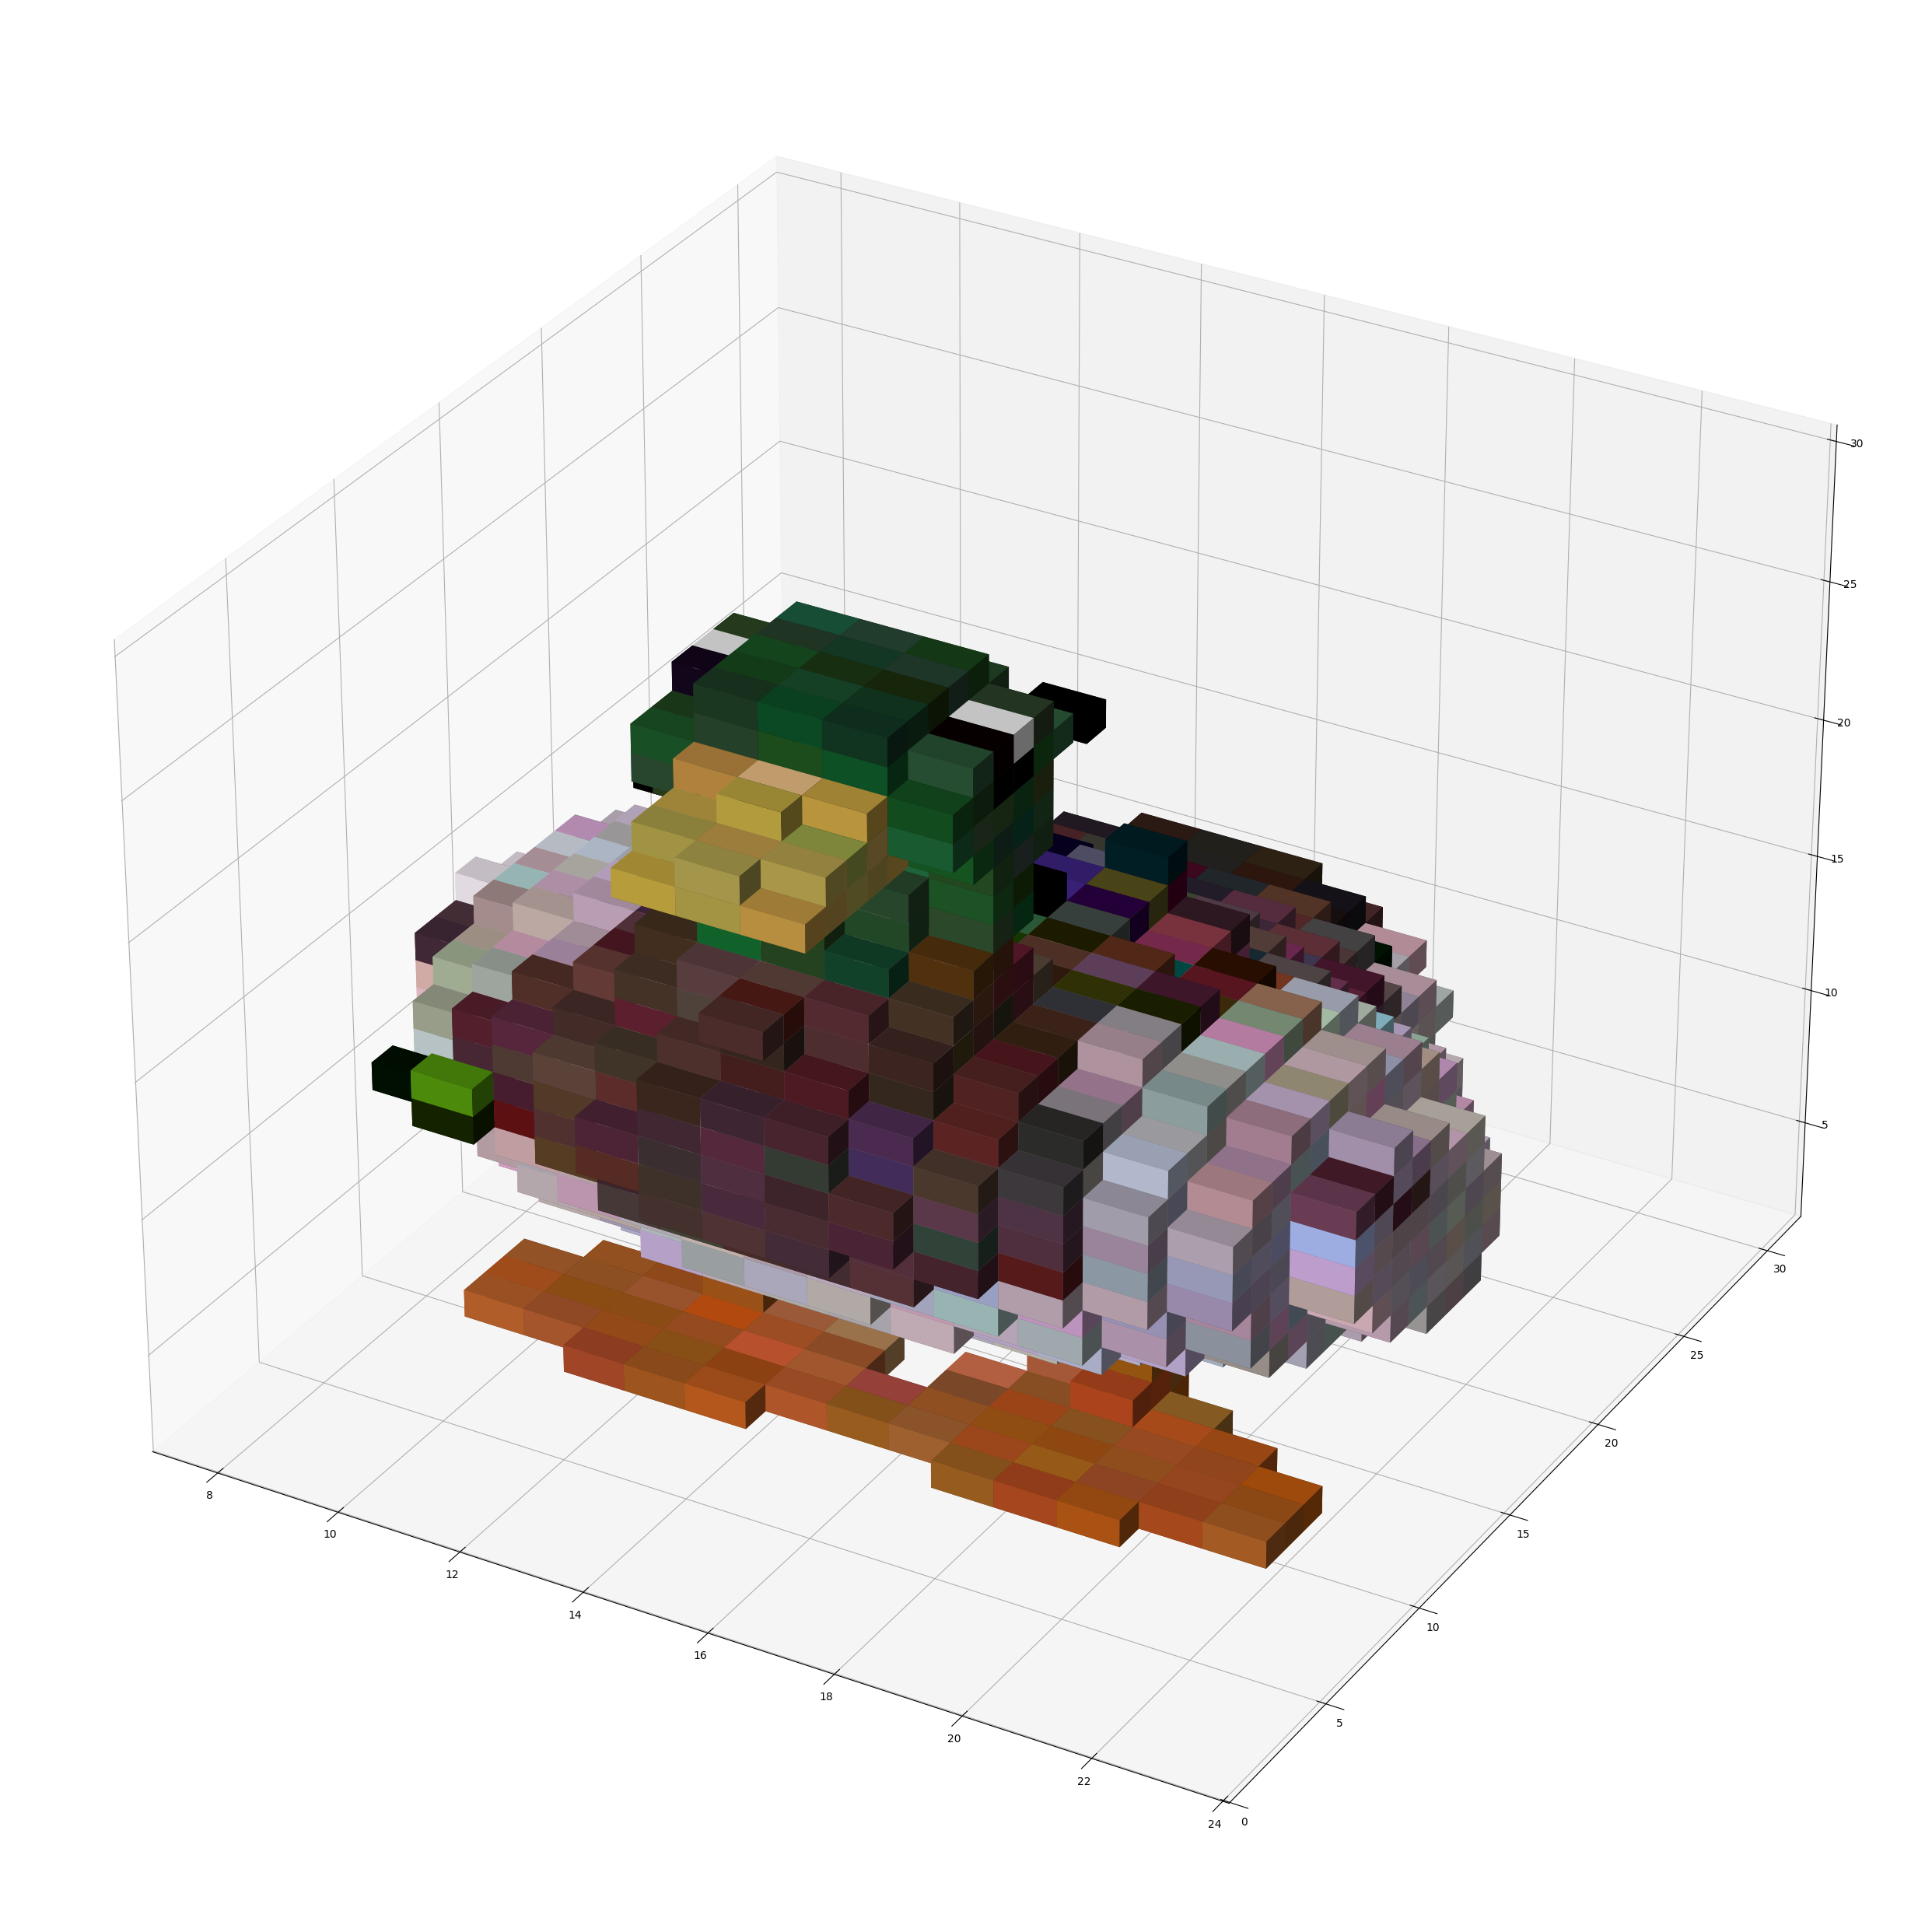

In [16]:
model.eval()
eval_iter = 64
torch.cuda.empty_cache()
with torch.no_grad():
    x = model.seed.unsqueeze(0)
    for i in range(eval_iter):
        x = model(x)
        # print(f"Iteration {i}: Loss{model.get_loss(x, rgba_voxels)[0].item()}")
    voxel_plot(torch.clamp(x[0, :4], min=0., max=1.))

### Video Generation

In [17]:
# NOTE: ENSURE THE BELOW OUTPUT PATHS ARE CORRECT FOR YOU!

model.eval()
num_imgs = 100
img_dir = "/data/grickus/N3CTAR/test/imgs"
video_dir = "/data/grickus/N3CTAR/test"

with torch.no_grad():
    x = model.seed.unsqueeze(0)
    voxel_plot(torch.clamp(x[0, :4], min=0., max=1.), save_fig=True, img_dir=img_dir, iter=0)
    for i in tqdm(range(num_imgs)):
        x = model(x)
        voxel_plot(torch.clamp(x[0, :4], min=0., max=1.), save_fig=True, img_dir=img_dir, iter=i+1)


  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
file_list = [os.path.join(img_dir, model_name, f"voxel_{i}.png") for i in range(num_imgs+1)]

clip = ImageSequenceClip(file_list, fps=12)
clip.write_videofile(os.path.join(video_dir, f"{model_name}.mp4"))

MoviePy - Building video /data/grickus/N3CTAR/test/trial_4.mp4.
MoviePy - Writing video /data/grickus/N3CTAR/test/trial_4.mp4



MoviePy - Done !
MoviePy - video ready /data/grickus/N3CTAR/test/trial_4.mp4
